In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
from PIL import Image
import glob
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import time
# Định nghĩa dataset
class FaceRecognitionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        
        folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f)) ]
        for idx, folder in enumerate(sorted(folders)):
            self.label_to_idx[folder] = idx
            image_files = glob.glob(os.path.join(root_dir, folder, "*.jpg")) + \
                         glob.glob(os.path.join(root_dir, folder, "*.png"))
            for img_path in image_files:
                self.image_paths.append(img_path)
                self.labels.append(idx)
        
        self.num_classes = len(self.label_to_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Hàm huấn luyện mô hình
def train_model(model, dataloader, criterion, optimizer, num_epochs=5, device='cuda'):
    model.train()
    all_losses = []
    all_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100 * correct / total
        all_losses.append(epoch_loss)
        all_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Vẽ chung một biểu đồ
    epochs = range(1, num_epochs + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, all_losses, color=color, marker='o', label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # tạo trục y thứ 2
    color = 'tab:green'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(epochs, all_accuracies, color=color, marker='s', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Training Loss and Accuracy")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

# Hàm đánh giá mô hình
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Tính F1 score, precision, recall
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    # In báo cáo chi tiết
    print("Classification Report:")
    label_to_idx = dataloader.dataset.label_to_idx
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    target_names = [idx_to_label[i] for i in range(len(label_to_idx))]
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    return f1, precision, recall


# Hàm dự đoán và kiểm tra thời gian
def predict(model, image, transform, label_to_idx, device='cuda', threshold=0.7):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        max_prob, predicted = torch.max(probabilities, 1)
        # Kiểm tra ngưỡng để xác định unknown
        if max_prob.item() < threshold:
            result = "Unknown"
        else:
            # Lấy tên nhãn từ chỉ số
            idx_to_label = {v: k for k, v in label_to_idx.items()}
            result = f"{idx_to_label[predicted.item()]} (Prob: {max_prob.item():.4f})"
    end_time = time.time()
    inference_time = end_time - start_time
    return result, inference_time

# Hàm dự đoán cho toàn bộ ảnh trong một thư mục
def predict_folder(model, folder_path, transform, label_to_idx, device='cuda', threshold=0.8):
    print(f"\nPredicting images in folder: {folder_path}")
    
    # Lấy danh sách tất cả ảnh trong thư mục (hỗ trợ .jpg và .png)
    image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                  glob.glob(os.path.join(folder_path, "*.png"))
    
    if not image_files:
        print("No images found in the folder. Please check the directory.")
        return
    
    # Lưu kết quả dự đoán
    results = []
    total_inference_time = 0.0
    prediction_counts = {}

    for img_path in image_files:
        try:
            img = Image.open(img_path).convert('RGB')
            result, inference_time = predict(model, img, transform, label_to_idx, device, threshold)
            
            # In kết quả cho từng ảnh
            print(f"Image: {os.path.basename(img_path)}")
            print(f"Prediction: {result}")
            print(f"Inference time: {inference_time:.6f} seconds")
            print("-" * 50)
            
            results.append((img_path, result, inference_time))
            total_inference_time += inference_time
            
            # Đếm số lượng dự đoán cho mỗi nhãn
            label = result.split(" (")[0]  # Lấy nhãn (bỏ phần xác suất)
            prediction_counts[label] = prediction_counts.get(label, 0) + 1
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    # In tóm tắt
    print("\nSummary:")
    print(f"Total images processed: {len(results)}")
    print(f"Average inference time: {total_inference_time / len(results):.6f} seconds")
    print("\nPrediction counts:")
    for label, count in prediction_counts.items():
        print(f"{label}: {count} images")


c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.2252, Accuracy: 93.54%
Epoch 2/20, Loss: 0.1114, Accuracy: 96.36%
Epoch 3/20, Loss: 0.1048, Accuracy: 95.86%
Epoch 4/20, Loss: 0.1093, Accuracy: 96.62%
Epoch 5/20, Loss: 0.0888, Accuracy: 96.52%
Epoch 6/20, Loss: 0.0560, Accuracy: 98.38%
Epoch 7/20, Loss: 0.0451, Accuracy: 98.33%
Epoch 8/20, Loss: 0.0367, Accuracy: 98.79%
Epoch 9/20, Loss: 0.0197, Accuracy: 99.55%
Epoch 10/20, Loss: 0.0193, Accuracy: 99.49%
Epoch 11/20, Loss: 0.0234, Accuracy: 99.19%
Epoch 12/20, Loss: 0.0218, Accuracy: 99.49%
Epoch 13/20, Loss: 0.0195, Accuracy: 99.44%
Epoch 14/20, Loss: 0.0092, Accuracy: 99.80%
Epoch 15/20, Loss: 0.0033, Accuracy: 100.00%
Epoch 16/20, Loss: 0.0204, Accuracy: 99.44%
Epoch 17/20, Loss: 0.0281, Accuracy: 99.24%
Epoch 18/20, Loss: 0.0104, Accuracy: 99.70%
Epoch 19/20, Loss: 0.0059, Accuracy: 99.75%
Epoch 20/20, Loss: 0.0025, Accuracy: 99.95%


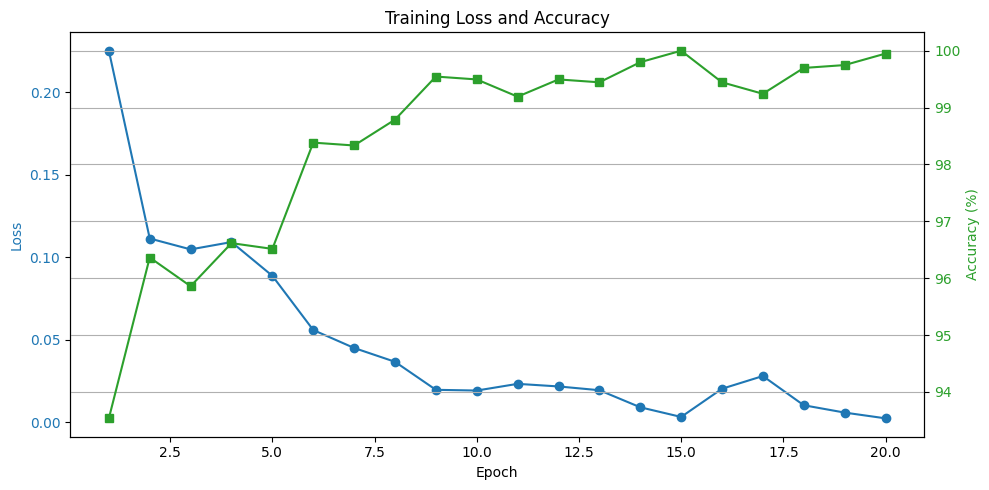


Đánh giá trên tập huấn luyện:
Classification Report:
                      precision    recall  f1-score   support

                Luan       1.00      1.00      1.00        18
               Trung       1.00      1.00      1.00         7
                Tuan       1.00      1.00      1.00        20
temp_20250417_160515       0.91      1.00      0.95        10
              thinh2       0.71      1.00      0.83        20
     thinh_in_school       1.00      1.00      1.00        20
             unknown       1.00      1.00      1.00      1885

            accuracy                           1.00      1980
           macro avg       0.95      1.00      0.97      1980
        weighted avg       1.00      1.00      1.00      1980

F1 Score: 0.9958, Precision: 0.9967, Recall: 0.9955

Đánh giá trên tập test:
Classification Report:
                      precision    recall  f1-score   support

                Luan       1.00      1.00      1.00        18
               Trung       1.00     

In [3]:

# Thiết lập và huấn luyện
if __name__ == "__main__":
    # Thiết lập device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Tạo dataset và dataloader cho tập huấn luyện
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet18 yêu cầu kích thước 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ImageNet
    ])
    train_dataset = FaceRecognitionDataset(root_dir=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Khởi tạo mô hình ResNet18
    model = models.resnet18(pretrained=False)  # Không sử dụng pretrained
    model.fc = nn.Linear(model.fc.in_features, train_dataset.num_classes)  # Điều chỉnh lớp cuối
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Huấn luyện mô hình
    train_model(model, train_dataloader, criterion, optimizer, num_epochs=20, device=device)

    # Đánh giá trên tập huấn luyện
    print("\nĐánh giá trên tập huấn luyện:")
    f1, precision, recall = evaluate_model(model, train_dataloader, device)
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Tạo dataset và dataloader cho tập test
    test_dataset = FaceRecognitionDataset(root_dir=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Đánh giá trên tập test
    print("\nĐánh giá trên tập test:")
    f1, precision, recall = evaluate_model(model, test_dataloader, device)
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


In [9]:

predict_folder_path = r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\unknown"
predict_folder(model, predict_folder_path, transform, train_dataset.label_to_idx, device=device, threshold=0.9)



Predicting images in folder: C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\unknown
Image: face_00001_0.png
Prediction: unknown (Prob: 1.0000)
Inference time: 0.033856 seconds
--------------------------------------------------
Image: face_00002_0.png
Prediction: unknown (Prob: 0.9992)
Inference time: 0.028598 seconds
--------------------------------------------------
Image: face_00005_0.png
Prediction: unknown (Prob: 1.0000)
Inference time: 0.040555 seconds
--------------------------------------------------
Image: face_00007_0.png
Prediction: unknown (Prob: 0.9998)
Inference time: 0.044266 seconds
--------------------------------------------------
Image: face_00008_0.png
Prediction: unknown (Prob: 0.9999)
Inference time: 0.020345 seconds
--------------------------------------------------
Image: face_00010_0.png
Prediction: unknown (Prob: 1.0000)
Inference time: 0.022290 seconds
--------------------------------------------------
Image: face_00011_0.png
Prediction: unknown (Prob

In [3]:
predict_folder_path = r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\temp_20250413_215507"
predict_folder(model, predict_folder_path, transform, train_dataset.label_to_idx, device=device, threshold=0.9)



Predicting images in folder: C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\temp_20250413_215507
Image: face_00000_0.png
Prediction: temp_20250413_215507 (Prob: 0.9790)
Inference time: 0.005808 seconds
--------------------------------------------------
Image: face_00001_0.png
Prediction: temp_20250413_215507 (Prob: 0.9380)
Inference time: 0.005189 seconds
--------------------------------------------------
Image: face_00002_0.png
Prediction: temp_20250413_215507 (Prob: 0.9804)
Inference time: 0.007254 seconds
--------------------------------------------------
Image: face_00003_0.png
Prediction: temp_20250413_215507 (Prob: 0.9397)
Inference time: 0.005301 seconds
--------------------------------------------------
Image: face_00004_0.png
Prediction: Unknown
Inference time: 0.006061 seconds
--------------------------------------------------
Image: face_00005_0.png
Prediction: temp_20250413_215507 (Prob: 0.9082)
Inference time: 0.008174 seconds
-------------------------------------

In [4]:
predict_folder_path = r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\temp_20250417_160515"
predict_folder(model, predict_folder_path, transform, train_dataset.label_to_idx, device=device, threshold=0.9)



Predicting images in folder: C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\temp_20250417_160515
Image: face_00000_0.png
Prediction: temp_20250417_160515 (Prob: 0.9931)
Inference time: 0.003548 seconds
--------------------------------------------------
Image: face_00001_0.png
Prediction: temp_20250417_160515 (Prob: 0.9975)
Inference time: 0.004600 seconds
--------------------------------------------------
Image: face_00002_0.png
Prediction: temp_20250417_160515 (Prob: 0.9993)
Inference time: 0.003346 seconds
--------------------------------------------------
Image: face_00003_0.png
Prediction: temp_20250417_160515 (Prob: 0.9834)
Inference time: 0.003748 seconds
--------------------------------------------------
Image: face_00004_0.png
Prediction: temp_20250417_160515 (Prob: 0.9921)
Inference time: 0.002785 seconds
--------------------------------------------------
Image: face_00005_0.png
Prediction: temp_20250417_160515 (Prob: 0.9685)
Inference time: 0.005434 seconds
---------

In [14]:
predict_folder_path = r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\thinh2"
predict_folder(model, predict_folder_path, transform, train_dataset.label_to_idx, device=device, threshold=0.9)



Predicting images in folder: C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces\thinh2
Image: face_00000.png
Prediction: Unknown
Inference time: 0.167533 seconds
--------------------------------------------------
Image: face_00001.png
Prediction: Unknown
Inference time: 0.153716 seconds
--------------------------------------------------
Image: face_00002.png
Prediction: Unknown
Inference time: 0.003747 seconds
--------------------------------------------------
Image: face_00003.png
Prediction: Unknown
Inference time: 0.001952 seconds
--------------------------------------------------
Image: face_00004.png
Prediction: Unknown
Inference time: 0.000000 seconds
--------------------------------------------------
Image: face_00005.png
Prediction: Unknown
Inference time: 0.000000 seconds
--------------------------------------------------
Image: face_00006.png
Prediction: Unknown
Inference time: 0.015591 seconds
--------------------------------------------------
Image: face_00007.png
Pred

In [7]:
import os
import cv2
import time
from datetime import datetime
import face_recognition
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, models

def predict(model, image, transform, label_to_idx, device='cuda', threshold=1):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        max_prob, predicted = torch.max(probabilities, 1)
        if max_prob.item() < threshold:
            result = "Unknown"
        else:
            idx_to_label = {v: k for k, v in label_to_idx.items()}
            result = f"{idx_to_label[predicted.item()]} (Prob: {max_prob.item():.4f})"
    end_time = time.time()
    inference_time = end_time - start_time
    return result, inference_time

class FaceRecognitionSystem:
    def __init__(self, dataset_path=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", detection_method="hog", model_path="face_recognition_model_res_net.pth"):
        self.dataset_path = dataset_path
        self.detection_method = detection_method
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Transform cho ResNet18
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # ResNet18 yêu cầu kích thước 224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ImageNet
        ])
        
        # Tạo danh sách nhãn
        self.label_to_idx = {}
        folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
        for idx, folder in enumerate(sorted(folders)):
            self.label_to_idx[folder] = idx
        self.num_classes = len(self.label_to_idx)
        
        # Khởi tạo mô hình ResNet18
        self.model = models.resnet18(pretrained=False)  # Không sử dụng pretrained
        self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)  # Điều chỉnh lớp cuối
        self.model = self.model.to(self.device)
        
        # Tải trạng thái mô hình
        try:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.eval()
            print(f"✅ Mô hình ResNet18 đã được tải từ {model_path}")
        except Exception as e:
            print(f"❌ Lỗi khi tải mô hình: {e}")
            print("Vui lòng huấn luyện lại mô hình ResNet18 với dataset hiện tại.")

    def draw_rectangles(self, frame, top, right, bottom, left, label="Face"):
        padding = 0
        top = max(0, top - padding)
        left = max(0, left - padding)
        right = min(frame.shape[1], right + padding)
        bottom = min(frame.shape[0], bottom + padding)
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(frame, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return frame

    def capture_images(self, num_images=10, person_name=None):
        if person_name:
            output_dir = os.path.join(self.dataset_path, person_name)
        else:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_dir = os.path.join(self.dataset_path, f"person_{timestamp}")
        
        os.makedirs(output_dir, exist_ok=True)
        print(f"📁 Lưu ảnh khuôn mặt vào thư mục: {output_dir}")

        video = cv2.VideoCapture(0)
        if not video.isOpened():
            print("❌ Không thể mở webcam")
            return

        print(f"🚀 Bắt đầu chụp {num_images} ảnh khuôn mặt...")
        count = 0
        while count < num_images:
            ret, frame = video.read()
            if not ret:
                print("❌ Không thể lấy khung hình từ webcam")
                break

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_locations = face_recognition.face_locations(rgb_frame, model=self.detection_method)

            if face_locations:
                top, right, bottom, left = face_locations[0]
                padding = 0
                top = max(0, top - padding)
                left = max(0, left - padding)
                right = min(frame.shape[1], right + padding)
                bottom = min(frame.shape[0], bottom + padding)

                face_img = frame[top:bottom, left:right]
                face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                face_img_pil = Image.fromarray(face_img_rgb)

                result, _ = predict(self.model, face_img_pil, self.transform, self.label_to_idx, self.device)
                frame = self.draw_rectangles(frame, top, right, bottom, left, label=result)

                filename = f"face_{count:05d}.png"
                filepath = os.path.join(output_dir, filename)
                cv2.imwrite(filepath, face_img)
                print(f"📸 Đã lưu khuôn mặt thứ {count + 1}/{num_images}: {filepath}")
                count += 1
            else:
                print(f"⚠️ Không phát hiện khuôn mặt trong khung hình thứ {count + 1}")
                cv2.imshow("Face Detection", frame)

            cv2.imshow("Face Detection", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                print("🛑 Người dùng đã thoát")
                break
            time.sleep(1)

        video.release()
        cv2.destroyAllWindows()
        print(f"✅ Hoàn tất! Đã lưu {count} ảnh khuôn mặt vào {output_dir}")

    def recognize_faces(self):
        video = cv2.VideoCapture(0)
        if not video.isOpened():
            print("❌ Không thể mở webcam")
            return

        print("🚀 Bắt đầu nhận diện khuôn mặt từ webcam...")
        while True:
            ret, frame = video.read()
            if not ret:
                print("❌ Không thể lấy khung hình từ webcam")
                break

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_locations = face_recognition.face_locations(rgb_frame, model=self.detection_method)

            for top, right, bottom, left in face_locations:
                padding = 0
                top_padded = max(0, top - padding)
                left_padded = max(0, left - padding)
                right_padded = min(frame.shape[1], right + padding)
                bottom_padded = min(frame.shape[0], bottom + padding)

                face_img = frame[top_padded:bottom_padded, left_padded:right_padded]
                face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                face_img_pil = Image.fromarray(face_img_rgb)

                result, _ = predict(self.model, face_img_pil, self.transform, self.label_to_idx, self.device)
                frame = self.draw_rectangles(frame, top, right, bottom, left, label=result)

            cv2.imshow("Face Recognition", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                print("🛑 Người dùng đã thoát")
                break

        video.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    frs = FaceRecognitionSystem(dataset_path=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", model_path=r"C:\Users\Divu\Desktop\DADN\detect_face\face_recognition_model_res_net.pth")
    mode = input("Chọn chế độ (1: Chụp ảnh, 2: Nhận diện): ").strip()
    if mode == "1":
        person_name = input("Nhập tên người (hoặc để trống để dùng timestamp): ").strip()
        frs.capture_images(num_images=10, person_name=person_name if person_name else None)
    elif mode == "2":
        frs.recognize_faces()

c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


❌ Lỗi khi tải mô hình: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([8, 512]) from checkpoint, the shape in current model is torch.Size([7, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([7]).
Vui lòng huấn luyện lại mô hình ResNet18 với dataset hiện tại.
🚀 Bắt đầu nhận diện khuôn mặt từ webcam...
🛑 Người dùng đã thoát
